In [1]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['d:\\BAMT', 'd:\\', 'd:\\BAMT\\tutorials']


In [2]:
import bamt.Networks as Nets
import bamt.Preprocessors as pp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from bamt.Builders import StructureBuilder

from pgmpy.estimators import K2Score
from gmr import GMM
import seaborn as sns

In [3]:
data = pd.read_csv(r'../Data/real data/hack_processed_with_rf.csv')

In [4]:
cols = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[cols]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [5]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(data)

In [6]:
bn = Nets.HybridBN(has_logit=False, use_mixture=False) # init BN
info = p.info

In [7]:
bn.add_nodes(info)

In [8]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,Discrete,disc,[],[]
2,Lithology,Discrete,disc,[],[]
3,Structural setting,Discrete,disc,[],[]
4,Gross,Gaussian (LinearRegression),cont,[],[]
5,Netpay,Gaussian (LinearRegression),cont,[],[]
6,Porosity,Gaussian (LinearRegression),cont,[],[]
7,Permeability,Gaussian (LinearRegression),cont,[],[]
8,Depth,Gaussian (LinearRegression),cont,[],[]


In [9]:
bn.add_edges(discretized_data,  scoring_function=('K2',K2Score))

  0%|          | 11/1000000 [00:00<15:24:08, 18.03it/s]


In [10]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Lithology,Discrete,disc,[],[]
2,Structural setting,Discrete,disc,[Tectonic regime],[disc]
3,Period,Discrete,disc,[Structural setting],[disc]
4,Porosity,ConditionalGaussian (LinearRegression),cont,[Period],[disc]
5,Gross,ConditionalGaussian (LinearRegression),cont,"[Period, Lithology, Structural setting]","[disc, disc, disc]"
6,Permeability,ConditionalGaussian (LinearRegression),cont,"[Porosity, Lithology]","[cont, disc]"
7,Depth,ConditionalGaussian (LinearRegression),cont,"[Porosity, Structural setting]","[cont, disc]"
8,Netpay,Gaussian (LinearRegression),cont,[Gross],[cont]


In [11]:
bn.fit_parameters(data)

In [12]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Lithology,Discrete,disc,[],[]
2,Structural setting,Discrete,disc,[Tectonic regime],[disc]
3,Period,Discrete,disc,[Structural setting],[disc]
4,Porosity,ConditionalGaussian (LinearRegression),cont,[Period],[disc]
5,Gross,ConditionalGaussian (LinearRegression),cont,"[Period, Lithology, Structural setting]","[disc, disc, disc]"
6,Permeability,ConditionalGaussian (LinearRegression),cont,"[Porosity, Lithology]","[cont, disc]"
7,Depth,ConditionalGaussian (LinearRegression),cont,"[Porosity, Structural setting]","[cont, disc]"
8,Netpay,Gaussian (LinearRegression),cont,[Gross],[cont]


In [13]:
sample = bn.sample(2500)

100%|██████████| 2500/2500 [00:00<00:00, 3135.25it/s]


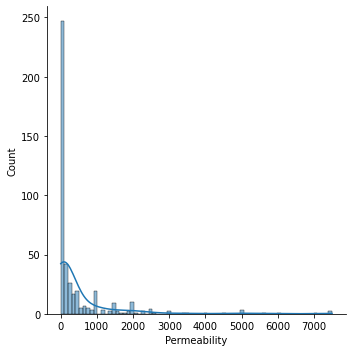

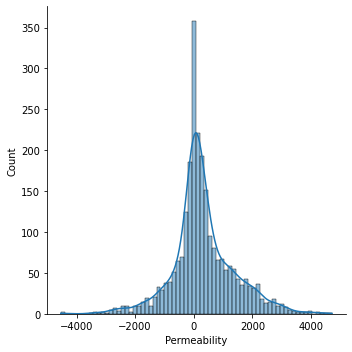

In [14]:
sns.displot(data['Permeability'], kde=True)
sns.displot(sample['Permeability'], kde=True)

In [15]:
pred = bn.predict(data[['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity', 'Depth']], parall_count=4)

100%|██████████| 442/442 [00:03<00:00, 111.65it/s]


In [16]:
mean_squared_error(data['Permeability'].values, pred['Permeability'], squared=False)

818.9467578310105

In [17]:
bn.set_regressor(regressors={'Permeability': XGBRegressor()})

In [18]:
bn.fit_parameters(data)

2022-10-21 16:17:11,344 | WARNING  | Nodes.py-fit_parameters-0433 | Permeability ['BASEMENT']::Pickle failed. BAMT will use Joblib. | [16:17:11] C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/common/json.cc:458: Expecting: """, got: "39 ", around character position: 1
    {'Config'
    ^~~~~~~~~
2022-10-21 16:17:11,398 | WARNING  | Nodes.py-fit_parameters-0433 | Permeability ['CHALK']::Pickle failed. BAMT will use Joblib. | [16:17:11] C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/common/json.cc:458: Expecting: """, got: "39 ", around character position: 1
    {'Config'
    ^~~~~~~~~
2022-10-21 16:17:11,457 | WARNING  | Nodes.py-fit_parameters-0433 | Permeability ['CHALKY LIMESTONE']::Pickle failed. BAMT will use Joblib. | [16:17:11] C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/common/json.cc:458: Expecting: """, got: "39 ", around character position: 1
    {'Config'
    ^~~~~~~~~
2022-10-21 16:17:11,508 | WARNING  | Nodes.py-fit_

In [19]:
sample = bn.sample(2500)

100%|██████████| 2500/2500 [01:05<00:00, 38.32it/s]


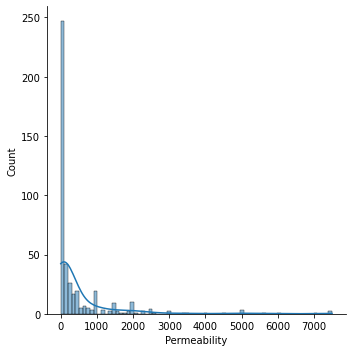

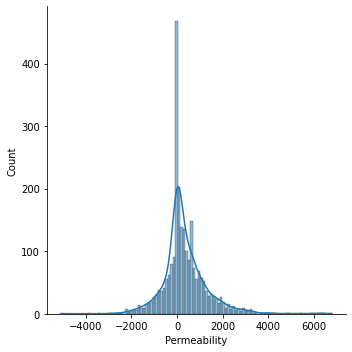

In [20]:
sns.displot(data['Permeability'], kde=True)
sns.displot(sample['Permeability'], kde=True)

In [21]:
pred = bn.predict(data[['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity', 'Depth']])

100%|██████████| 442/442 [00:13<00:00, 33.93it/s]


In [22]:
mean_squared_error(data['Permeability'].values, pred['Permeability'], squared=False)

713.525151340728